In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import shap
from sklearn.inspection import permutation_importance

In [21]:

train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')


X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

print("Dados originais - Train shape:", X_train.shape)
print("Distribuição original:", pd.Series(y_train).value_counts().to_dict())


Dados originais - Train shape: (5301, 40)
Distribuição original: {2: 1767, 0: 1767, 1: 1767}


In [22]:
def simple_feature_engineering(X_train, X_test):
    print("=== APLICANDO FEATURE ENGINEERING ===")
    
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    
    numeric_cols = X_train.select_dtypes(include=['number']).columns[:5]
    print(f"Usando top 5 colunas numéricas: {list(numeric_cols)}")
    

    X_train_new['sum_top5'] = X_train[numeric_cols].sum(axis=1)
    X_test_new['sum_top5'] = X_test[numeric_cols].sum(axis=1)
    
    X_train_new['mean_top5'] = X_train[numeric_cols].mean(axis=1)
    X_test_new['mean_top5'] = X_test[numeric_cols].mean(axis=1)
    
    print(f"Features originais: {X_train.shape[1]}")
    print(f"Features após engineering: {X_train_new.shape[1]}")
    print("=== FEATURE ENGINEERING CONCLUÍDO ===")
    
    return X_train_new, X_test_new

# Aplicar feature engineering
X_train, X_test = simple_feature_engineering(X_train, X_test)

=== APLICANDO FEATURE ENGINEERING ===
Usando top 5 colunas numéricas: ['Application mode', 'Application order', 'Course', 'Previous qualification', 'Previous qualification (grade)']
Features originais: 40
Features após engineering: 42
=== FEATURE ENGINEERING CONCLUÍDO ===


In [23]:
print("Tipos de dados:")
print(X_train.dtypes.value_counts())

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas:", len(num_cols))
print("Booleanas:", len(bool_cols))
print("Categóricas:", len(cat_cols))

if bool_cols:
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_test[bool_cols] = X_test[bool_cols].astype(int)
    num_cols.extend(bool_cols)
    print("Colunas booleanas convertidas para int")

Tipos de dados:
float64    21
bool       13
int64       8
dtype: int64
Numéricas: 29
Booleanas: 13
Categóricas: 0
Colunas booleanas convertidas para int


In [24]:
num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median"))
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

In [25]:
tree = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", tree)
])

In [26]:
param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [5, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"],
    "clf__ccp_alpha": [0.0, 1e-5, 1e-4, 5e-4, 1e-3],
    'clf__class_weight': [None, 'balanced'],
}

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)
print("Melhores parâmetros:", gs.best_params_)
print("Score médio CV (métrica escolhida):", gs.best_score_)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


KeyboardInterrupt: 

In [ ]:
y_pred = gs.predict(X_test)

print("\nRelatório de classificação (teste):")
print(classification_report(y_test, y_pred, digits=4))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.6915    0.6866    0.6890       284
           1     0.3822    0.4591    0.4171       159
           2     0.8228    0.7670    0.7939       442

    accuracy                         0.6859       885
   macro avg     0.6322    0.6376    0.6334       885
weighted avg     0.7015    0.6859    0.6926       885


Matriz de confusão:
[[195  54  35]
 [ 48  73  38]
 [ 39  64 339]]


# Interpretabilidade — Árvore de Decisão
Nesta seção organizamos as saídas para explicar as decisões da árvore e identificar as features mais importantes.


#### Visualização do topo da árvore
Usamos `plot_tree(max_depth=3)` para mostrar as primeiras regras (mais estáveis). Leia: condição no nó → divisão da amostra → folhas com distribuição de classes.


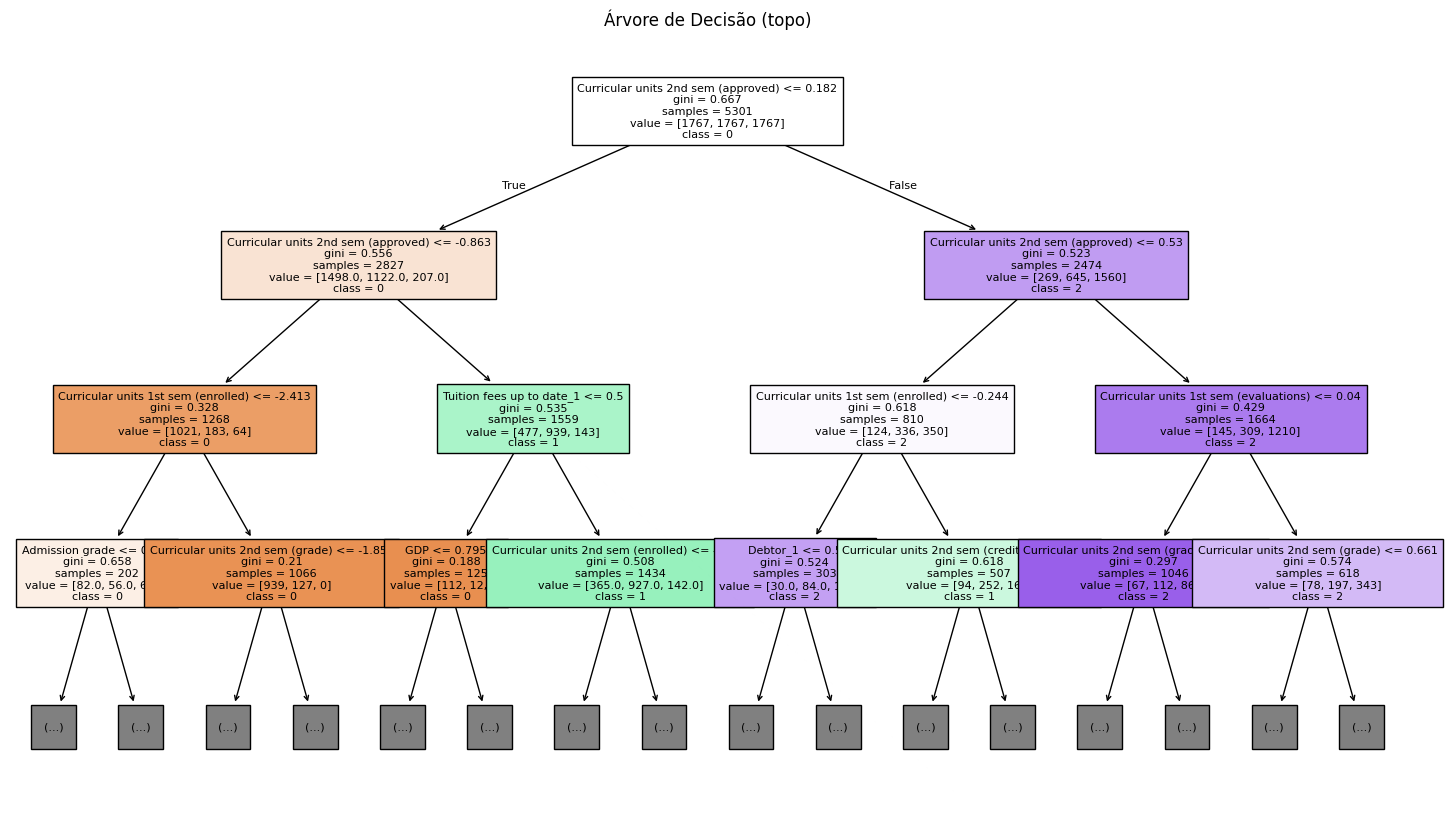

In [ ]:
plt.figure(figsize=(18, 10))
plot_tree(
    best_tree,
    filled=True,
    class_names=[str(c) for c in np.unique(y_train)],
    feature_names=feat_names,
    max_depth=3,
    fontsize=8
)
plt.title("Árvore de Decisão (topo)")
plt.show()

#### Importância de features (Gini)
Ranking Top-15 com `feature_importances_` (redução média de impureza). Valores maiores indicam maior ganho de pureza ao usar a feature nos splits.


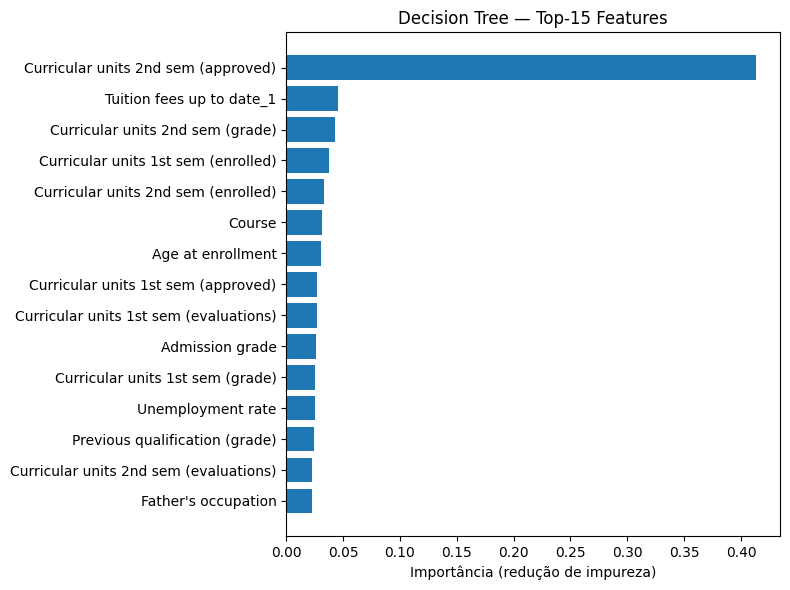

In [ ]:
importances_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
      .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,6))
plt.barh(
    y=importances_df["feature"].head(15)[::-1],
    width=importances_df["importance"].head(15)[::-1],
)
plt.xlabel("Importância (redução de impureza)")
plt.title("Decision Tree — Top-15 Features")
plt.tight_layout()
plt.show()

#### Importância de Permutação (F1-macro)
Sanidade global: mede a queda média de F1-macro ao embaralhar cada coluna do conjunto de teste. Quanto maior a queda, mais importante a feature.


,feature,mean_importance,std_importance
21,Curricular units 2nd sem (approved),0.229001,0.014091
19,Curricular units 2nd sem (enrolled),0.048612,0.012940
13,Curricular units 1st sem (enrolled),0.035454,0.005649
24,Unemployment rate,0.020553,0.004322
15,Curricular units 1st sem (approved),0.016943,0.005700
22,Curricular units 2nd sem (grade),0.016589,0.004073
2,Course,0.015976,0.006307
36,Educational special needs_1,0.015935,0.003909
14,Curricular units 1st sem (evaluations),0.014681,0.005158
20,Curricular units 2nd sem (evaluations),0.011213,0.005534


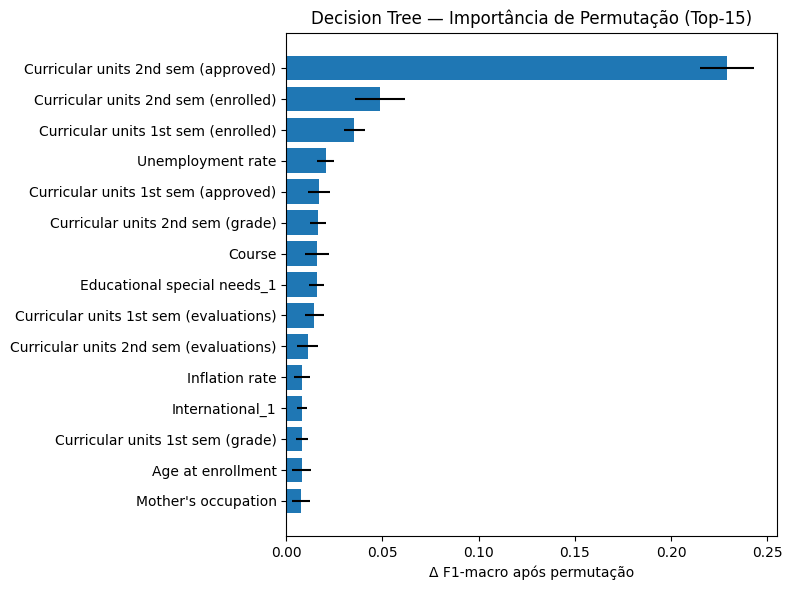

In [ ]:

perm_res = permutation_importance(
    best_pipe,
    X_test,
    y_test,
    scoring="f1_macro",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = (
    pd.DataFrame({
        "feature": feat_names,
        "mean_importance": perm_res.importances_mean,
        "std_importance": perm_res.importances_std
    })
    .sort_values("mean_importance", ascending=False)
)

display(perm_df.head(15))

plt.figure(figsize=(8,6))
plt.barh(
    perm_df["feature"].head(15)[::-1],
    perm_df["mean_importance"].head(15)[::-1],
    xerr=perm_df["std_importance"].head(15)[::-1]
)
plt.xlabel("Δ F1-macro após permutação")
plt.title("Decision Tree — Importância de Permutação (Top-15)")
plt.tight_layout()
plt.show()

#### Análise
- Convergência: “Curricular units 2nd sem (approved)” lidera nos dois métodos; demais variáveis curriculares (approved/grade/enrolled 1º–2º sem) também aparecem entre as mais relevantes.

- Divergência esperada: no Gini, Tuition fees up to date_1 surge muito alto; na Permutação, o impacto maior aparece em enrolled (1º/2º sem) e alguns indicadores administrativos/macroeconômicos (ex.: Unemployment rate, Educational special needs_1, International_1). Gini mede ganho de impureza nos splits; a Permutação mede queda real de F1 no teste quando uma coluna é embaralhada.

- Regras do topo da árvore são fáceis de comunicar e explicam boa parte das decisões; usamos a visualização limitada (max_depth=3) para manter a explicação estável, já que a árvore ótima é profunda (~30).
